In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [185]:
from Coil_contribution import Coil_contribution


coils = Coil_contribution("coils_symmetric.txt")

#######################
#upper plasma coil (2x symmetric)
rp=4.0; zp=0.25; jp=-2.0e4

#rp=4.5; zp=0.; jp=-10.0e4

#######################
# B0 coils (two separately)
# ....same as plasma
#rp01=4.0; zp01= 0.25; jp01=-2.0e4
#rp02=4.0; zp02=-0.25; jp02=-2.0e4
# ...similar as plasma
rp01=4.0; zp01= 0.01  ; jp01=-2.0e4
rp02=4.0; zp02=-0.01  ; jp02=-2.0e4
# ... different as plasma
#rp01=4.3; zp01= 0.  ; jp01=-2.0e4
#rp02=4.3; zp02=-0.  ; jp02=-2.0e4
# ... very different as plasma/unsymmetric
#rp01=3.6; zp01=-0.1  ; jp01=-1.5e4
#rp02=4.2; zp02=-0.5  ; jp02=-2.5e4

def eval_coil_psi(R,Z):
    '''Evaluates coil field '''
    psi_c = coils.eval_coil_field(R,Z)
    
    return psi_c


def eval_full_psi(R,Z):
    '''Evaluates coil field plus additional field from "coils" modelling for the plasma current '''
    psi_c = eval_coil_psi(R,Z)
    

    psi_p = coils.eval_multi_coil_field(R,Z,r_coils=[rp,rp],z_coils=[zp,-zp],j_coils=[jp,jp])

    
    psi=psi_c+psi_p
    
    return psi


def eval_full_Bpol(R,Z):
    '''Evaluates coil field plus additional field from "coils" modelling for the plasma current '''
    dpsi_dr_c,dpsi_dz_c = coils.eval_grad_coil_field(R,Z)
    
    dpsi_dr_p,dpsi_dz_p = coils.eval_grad_multi_coil_field(R,Z,r_coils=[rp,rp],z_coils=[zp,-zp],j_coils=[jp,jp])

    dpsi_dr=dpsi_dr_c+dpsi_dr_p
    dpsi_dz=dpsi_dz_c+dpsi_dz_p
    
    #Bpol_r=-dpsi_dz/R,Bpol_z=dpsi_dr/R
    return -dpsi_dz/R,dpsi_dr/R

def eval_psi_B0(R,Z):
    '''
    Evaluates coil field plus additional field from "coils" modelling for the plasma current. 
    Idea: this psi can be different to eval_full_psi, but should have the same  plasma current.
    '''
    psi_c = eval_coil_psi(R,Z)
    
    #use B0 coils

    psi_p1 = coils.eval_single_coil_field(R,Z,rp01,zp01,jp01)


    psi_p2 = coils.eval_single_coil_field(R,Z,rp02,zp02,jp02)
    
    psi=psi_c+psi_p1+psi_p2
    
    return psi

def eval_B0pol(R,Z):
    '''Evaluates coil field plus additional field from "coils" modelling for the plasma current '''
    dpsi_dr_c,dpsi_dz_c = coils.eval_grad_coil_field(R,Z)
    
    #use B0 coils
    
    dpsi_dr_p1,dpsi_dz_p1 = coils.eval_grad_single_coil_field(R,Z,rp01,zp01,jp01)

    dpsi_dr_p2,dpsi_dz_p2 = coils.eval_grad_single_coil_field(R,Z,rp02,zp02,jp02)
    
    dpsi_dr=dpsi_dr_c+dpsi_dr_p1+dpsi_dr_p2
    dpsi_dz=dpsi_dz_c+dpsi_dz_p1+dpsi_dz_p2
    
    #Bpol_r=-dpsi_dz/R,Bpol_z=dpsi_dr/R
    return -dpsi_dz/R,dpsi_dr/R


def eval_Bcoil(R,Z):
    '''Evaluates coil field plus additional field from "coils" modelling for the plasma current '''
    dpsi_dr,dpsi_dz = coils.eval_grad_coil_field(R,Z)
    
    #Bpol_r=-dpsi_dz/R,Bpol_z=dpsi_dr/R
    return -dpsi_dz/R,dpsi_dr/R


In [86]:

def get_RZ_grid( Rlim=[2,5], Zlim=[-2,2], h_RZ=1e-2):
    '''Get a meshgrid of a given domain size and uniform approximate grid size h'''
    Nr=int((Rlim[1]-Rlim[0])/h_RZ)
    Nz=int((Zlim[1]-Zlim[0])/h_RZ)
    r = np.linspace(Rlim[0], Rlim[1], Nr)
    z = np.linspace(Zlim[0], Zlim[1], Nz)
    R, Z = np.meshgrid(r, z)
    return R,Z


(0.1, 11.0, -7.0, 7.0)

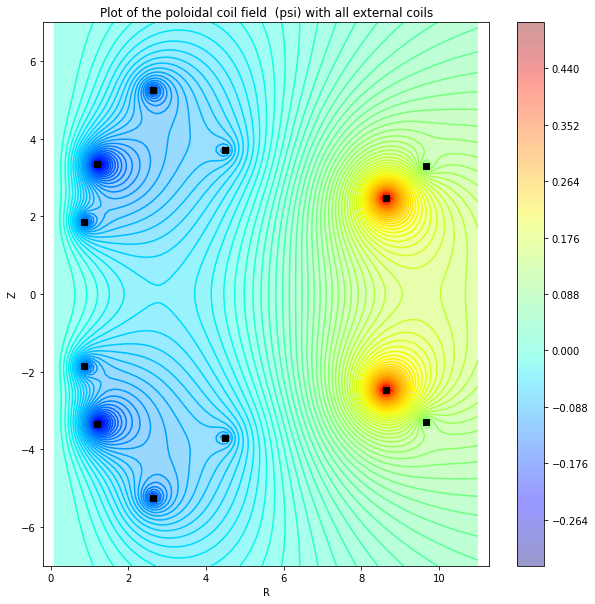

In [87]:
# visualize coil field

R,Z = get_RZ_grid(Rlim=[0.1,11],Zlim=[-7,7],h_RZ=0.1)
psi_c= eval_coil_psi(R,Z)
    

    
    
fig,ax= plt.subplots(figsize=(10,10))
    
im=ax.contourf(R, Z, psi_c, 120, cmap='jet',alpha=0.4)
ax.contour(R, Z, psi_c, 120,cmap='jet')

ax.plot(coils.coil_arr[:,0],coils.coil_arr[:,1],'ks')
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Plot of the poloidal coil field  (psi) with all external coils')
fig.colorbar(im)
ax.axis("equal")

(2.0, 5.0, -2.0, 2.0)

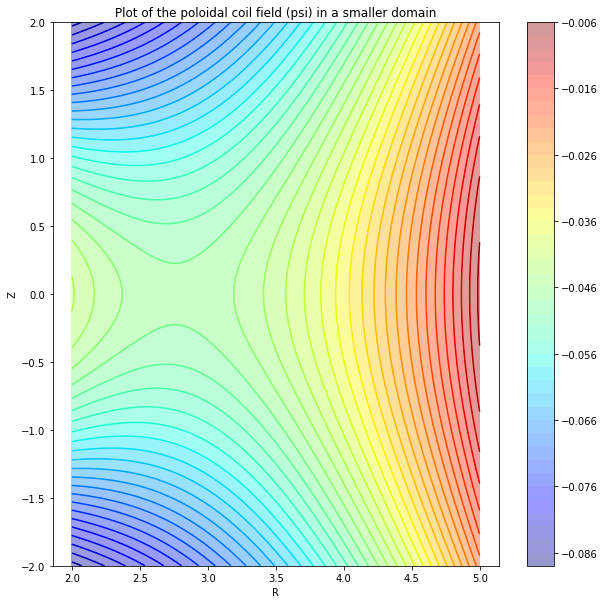

In [88]:
#visualize coild field in default domain
R,Z = get_RZ_grid()
psi_c= eval_coil_psi(R,Z)
    
fig,ax= plt.subplots(figsize=(10,10))
    
im=ax.contourf(R, Z, psi_c, 40, cmap='jet',alpha=0.4)
ax.contour(R, Z, psi_c, 40,cmap='jet')

#ax.plot(coils.coil_arr[:,0],coils.coil_arr[:,1],'bs')
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Plot of the poloidal coil field (psi) in a smaller domain')
fig.colorbar(im)
ax.axis("equal")

(2.0, 5.0, -2.0, 2.0)

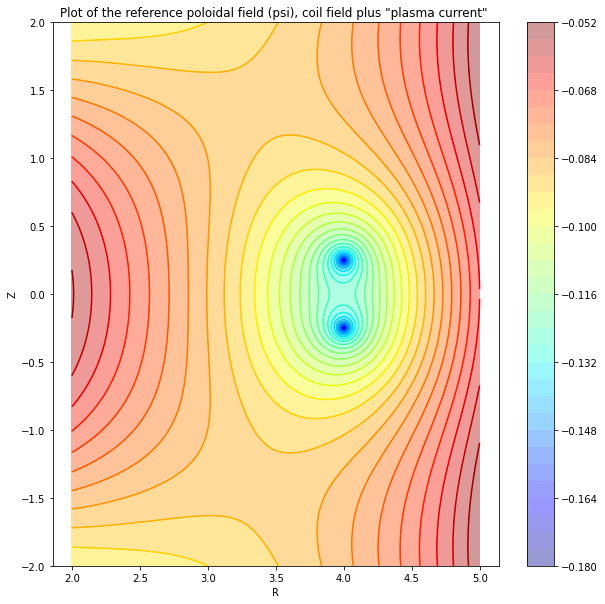

In [89]:
#visualize full field 
R,Z = get_RZ_grid()
psi= eval_full_psi(R,Z)
    
fig,ax= plt.subplots(figsize=(10,10))
    
im=ax.contourf(R, Z, psi, 40, cmap='jet',alpha=0.4)
ax.contour(R, Z, psi, 40,cmap='jet')


plt.xlabel('R')
plt.ylabel('Z')
plt.title('Plot of the reference poloidal field (psi), coil field plus "plasma current" ')
fig.colorbar(im)
ax.axis("equal")

In [90]:

def eval_1d_fourier(t,coef_c=[],coef_s=[]):
    '''Evaluates cosine/sine series, first coef_c is mode m=0, of coef_s is mode m=1'''
    x=0.0*t
    for m in range(0,len(coef_c)):
        x+=coef_c[m]*np.cos(m*t*2*np.pi)
    for m in range(0,len(coef_s)):
        x+=coef_s[m]*np.sin((m+1)*t*2*np.pi)
    return x


def eval_1d_fourier_dt(t,coef_c=[],coef_s=[]):
    '''Evaluates first derivative of cosine/sine series, first coef_c is mode m=0, of coef_s is mode m=1'''
    dxdt=0.0*t
    for m in range(0,len(coef_c)):
        dxdt+=-m*2*np.pi*coef_c[m]*np.sin(m*t*2*np.pi)
    for m in range(0,len(coef_s)):
        dxdt+=(m+1)*2*np.pi*coef_s[m]*np.cos((m+1)*t*2*np.pi)
    return dxdt


def eval_curve(x,xmap,N):
    '''
    Evaluates r,z of the curve defined by fourier coefficients 
    rcoef_c/s and zcoef_c/s , at N points. coefficients are mapped from 1d array x, using xmap dict.
    '''
    thet=np.linspace(0.,1.,N,endpoint=False)
    rr=eval_1d_fourier(thet,
                       coef_c=x[xmap["str_r_c"]:xmap["str_r_c"]+xmap["nr_c"]],
                       coef_s=x[xmap["str_r_s"]:xmap["str_r_s"]+xmap["nr_s"]])

    zz=eval_1d_fourier(thet,
                       coef_c=x[xmap["str_z_c"]:xmap["str_z_c"]+xmap["nz_c"]],
                       coef_s=x[xmap["str_z_s"]:xmap["str_z_s"]+xmap["nz_s"]])
    return rr,zz


def eval_curve_dt(x,xmap,N):
    '''
    Evaluates r,z of the curve defined by fourier coefficients 
    rcoef_c/s and zcoef_c/s , at N points. coefficients are mapped from 1d array x, using xmap dict.
    '''
    thet=np.linspace(0.,1.,N,endpoint=False)
    dr_dt=eval_1d_fourier_dt(thet,
                       coef_c=x[xmap["str_r_c"]:xmap["str_r_c"]+xmap["nr_c"]],
                       coef_s=x[xmap["str_r_s"]:xmap["str_r_s"]+xmap["nr_s"]])

    dz_dt=eval_1d_fourier_dt(thet,
                       coef_c=x[xmap["str_z_c"]:xmap["str_z_c"]+xmap["nz_c"]],
                       coef_s=x[xmap["str_z_s"]:xmap["str_z_s"]+xmap["nz_s"]])
    return dr_dt,dz_dt

def eval_curve_normal(x,xmap,N):
    dr_dt,dz_dt=eval_curve_dt(x,xmap,N)
    nn=np.sqrt(dr_dt**2+dz_dt**2)
    return dz_dt/nn, -dr_dt/nn  # n_r,n_z


psi_fs -8.897973e-02, max abs (psi_contour-psi_fs)= 7.460935e-07
psi_fs -8.897973e-02, initial residual,sqrt||(psi_point-psi_fs)^2/psi_fs^2||= 1.043403e-02 
message minimizer_point: Desired error not necessarily achieved due to precision loss.
psi_fs -8.897973e-02, final residual,sqrt||(psi_point-psi_fs)^2/psi_fs^2||= 2.633140e-11 
final diff_psi |psi_point-psi_fs|= 3.313447e-12 
psi_fs -8.897973e-02, initial residual,sqrt||(psi_line-psi_fs)^2/psi_fs^2||= 6.290794e-03 
message minimizer_line: Desired error not necessarily achieved due to precision loss.
psi_fs -8.897973e-02, final residual,sqrt||(psi_line-psi_fs)^2/psi_fs^2||= 2.915668e-10 
=====m_max= 4 ====== 
psi_fs -8.897973e-02, initial residual= 1.430851e-02 
message minimizer: Desired error not necessarily achieved due to precision loss.
psi_fs -8.897973e-02, final residual = 6.246151e-07 
psi_fs -8.897973e-02, min/max (psi_fit-psi_fs)= -6.798342e-06 6.151054e-06
maximum error in |B.n|/|B|= 2.980294e-03
Mscale(p=1/2/4)= 1.023824

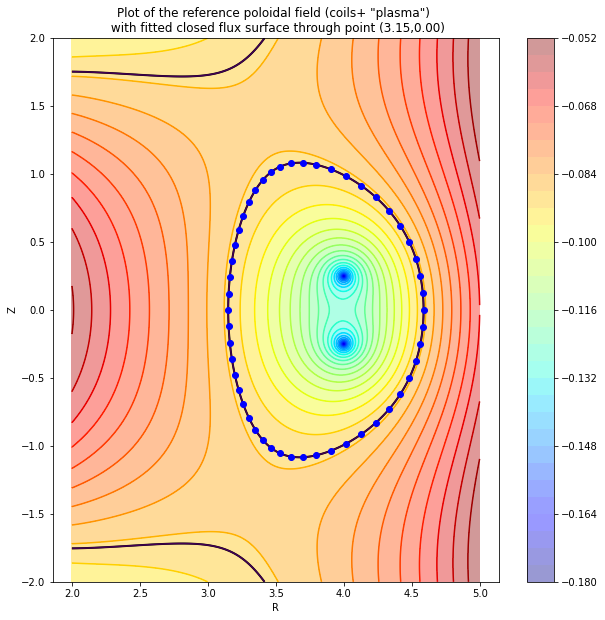

In [91]:
# FIND A PARAMETRIZATION OF THE CLOSED FLUX SURFACE
    

def psidiff(x_in,xmap,psi_goal,N):
    '''
    function for the minimizer: evaluate psi on the curve and 
    return the squared normalized difference to psi_goal
    '''
    rr,zz=eval_curve(x_in,xmap,N)
    psi_curve=eval_full_psi(rr,zz)
    return (psi_curve-psi_goal)**2/(psi_goal**2) 

def BdotN(x_in,xmap,N):
    rr,zz=eval_curve(x_in,xmap,N)
    Bpol_r,Bpol_z = eval_full_Bpol(rr,zz)
    
    dr_dt,dz_dt=eval_curve_dt(x_in,xmap,N)
    
    n_r=dz_dt;  n_z=-dr_dt
    return (n_r*Bpol_r+n_z*Bpol_z)**2/((Bpol_r**2+Bpol_z**2)*(n_r**2+n_z**2))
    


def Mscale(x_in,xmap,p=1,q=1):
    
    return np.sum(xmap["m"]**(p+q)*x_in**2)/np.sum(xmap["m"]**(p)*x_in**2)


def minf(x_in,xmap,psi_goal,N):
    '''
    function for the minimizer: 
    '''
    #return 0.5*np.sum(psidiff(x_in,xmap,psi_goal,N))/N 
    return 0.5*np.sum(psidiff(x_in,xmap,psi_goal,N))/N +0.5*np.sum(BdotN(x_in,xmap,N))/N #<==== add normal condition

#def minf_LS(x_in,xmap,psi_goal,N):
#    return psidiff(x_in,xmap,psi_goal,N) + BdotN(x_in,xmap,N)

def minf_point(x,psi_goal):
    return 0.5*(eval_full_psi(x[0],x[1])-psi_goal)**2/(psi_goal**2)

def eval_line(a,xp,xs):
    return [xp[0]+a*xs[0],xp[1]+a*xs[1]]

def minf_line(a,xp,xs,psi_goal):
    return minf_point(eval_line(a,xp,xs),psi_goal)

def psi_line(a,xp,xs,psi_goal):
    x=eval_line(a,xp,xs)
    return eval_full_psi(x[0],x[1])-psi_goal

def point_distance(x_in,xmap,N,rr_ref,zz_ref):
    rr,zz=eval_curve(x_in,xmap,N)
    return (rr-rr_ref)**2+(zz-zz_ref)**2

def minf_dist(x_in,xmap,N,rr_ref,zz_ref):
    return 0.5*np.sum(point_distance(x_in,xmap,N,rr_ref,zz_ref))/N


def find_flux_surface(r_fs=3.15,z_fs=0.,m_max_start=4,m_max_end=6,**kwargs):
    '''
    Main function to find a closed flux surface (with parametrization of the angle!) of the coil+plasma field. 
    Visualization helps if default parameters would change.
    Defines a contour(=flux surface) of psi at a given point (r_fs,z_fs), uses the contour object and extract the closed contour.
    The contour object gives a bounding box which is used to initialize the fourier series of the curve.
    Then the coefficients are optimized to match the contour level, 
    by minimizing the difference of the flux evaluated at the curve to the flux of the contour.
    '''
    from scipy.optimize import minimize
    from scipy.optimize import root

    
    R,Z = get_RZ_grid(**kwargs)
    psi= eval_full_psi(R,Z)
    
    #select flux surface going through the point:
    
    
    psi_fs =eval_full_psi(r_fs,z_fs) 
    
    
    fig,ax= plt.subplots(figsize=(10,10))
    
    im=ax.contourf(R, Z, psi, 40, cmap='jet',alpha=0.4)
    ax.contour(R, Z, psi, 40,cmap='jet')
   
    
    ax.contour(R,Z, psi, [psi_fs], colors='k', linewidths=2., linestyles='solid')
    

    # get the contour object
    fs = ax.contour(R, Z, psi, [psi_fs])
    
    fs_list = fs.collections[0].get_paths()
    # Sort the paths by its length. Assume main one is the longest(?)
    fs_list.sort(key=len, reverse=True)
    
    fs_coord = fs_list[0].vertices
    fs_r =fs_coord[:, 0]
    fs_z = fs_coord[:, 1]
    
    
    idx_left=np.argmin(fs_r[:])
    idx_right=np.argmax(fs_r[:])
    idx_lower=np.argmin(fs_z[:])
    idx_upper=np.argmax(fs_z[:])
    
    #print ("bound. box, left (%f,%f),right (%f,%f),lower (%f,%f),upper (%f,%f)" % (fs_r[idx_left],fs_z[idx_left],fs_r[idx_right],fs_z[idx_right],fs_r[idx_lower],fs_z[idx_lower],fs_r[idx_upper],fs_z[idx_upper]))
    #ax.plot(fs_r[0:-1:10],fs_z[0:-1:10],'bx')

    
    psi_back=eval_full_psi(fs_r,fs_z)
    
    print ("psi_fs %e, max abs (psi_contour-psi_fs)= %e" % (psi_fs,np.amax(np.abs(psi_back-psi_fs))))
    
    #testing minimizer with one point:
    x0_point=[3.5,1.2]
    diff_psi=minf_point(x0_point,psi_fs)
    print ("psi_fs %e, initial residual,sqrt||(psi_point-psi_fs)^2/psi_fs^2||= %e " % (psi_fs,np.sqrt(diff_psi)))
    
    res_point=minimize(minf_point, x0_point, args=(psi_fs),tol=1.0e-16)
    
    print("message minimizer_point: " +res_point.message)
    diff_psi=minf_point(res_point.x,psi_fs)
    print ("psi_fs %e, final residual,sqrt||(psi_point-psi_fs)^2/psi_fs^2||= %e " % (psi_fs,np.sqrt(diff_psi)))
    print ("final diff_psi |psi_point-psi_fs|= %e " % (np.sqrt(2*psi_fs**2*diff_psi)))
    # plt.plot([x0_point[0],res_point.x[0]],[x0_point[1],res_point.x[1]],'ro')
    
    #testing minimizer with point along line:
    x0_a=0.1;xp= [3.5,1.2];xs=[1,-0.5]
    diff_psi=minf_line(x0_a,xp,xs,psi_fs)
    print ("psi_fs %e, initial residual,sqrt||(psi_line-psi_fs)^2/psi_fs^2||= %e " % (psi_fs,np.sqrt(diff_psi)))
    res_line=minimize(minf_line, x0_a, args=(xp,xs,psi_fs),tol=1.0e-16)
    print("message minimizer_line: " +res_line.message)
    diff_psi=minf_line(res_line.x,xp,xs,psi_fs)
    print ("psi_fs %e, final residual,sqrt||(psi_line-psi_fs)^2/psi_fs^2||= %e " % (psi_fs,np.sqrt(diff_psi)))
    
    #################
    # find the contour parametrization
    #################
    all_results={}
    for m_max in range(m_max_start,m_max_end+1):
        print ("=====m_max= %d ====== " % (m_max))
        rcoef_c0=np.zeros(m_max+1)
        rcoef_s0=[] #up-down symmetric
        zcoef_c0=[] #up-down symmetric
        #rcoef_s0=np.zeros(m_max)   #unsymmetric
        #zcoef_c0=np.zeros(m_max+1) #unsymmetric
        zcoef_s0=np.zeros(m_max)
    
        # first initialization:
        # initialize  up-down symmetric curve inside bounding box of contour 
        if(m_max == m_max_start):
            #rcoef_c0[2]=0.1 #m=2
            rcoef_c0[1]=0.5*(fs_r[idx_right]-fs_r[idx_left]) # m=1
            rcoef_c0[0]=0.5*(fs_r[idx_right]+fs_r[idx_left]) #- rcoef_c0[2] # m=0
            zcoef_s0[0]=fs_z[idx_upper] #m=1
            #zcoef_s0[1]=-0.1 #m=2
        # use previous solution
        else:
            rcoef_c0[0:m_max]=res.x[xmap["str_r_c"]:xmap["str_r_c"]+xmap["nr_c"]]
            #rcoef_s0[0:m_max-1]  =res.x[xmap["str_r_s"]:xmap["str_r_s"]+xmap["nr_s"]]
            #zcoef_c0[0:m_max]=res.x[xmap["str_z_c"]:xmap["str_z_c"]+xmap["nz_c"]]
            zcoef_s0[0:m_max-1]  =res.x[xmap["str_z_s"]:xmap["str_z_s"]+xmap["nz_s"]]
    
    
        # BUILD 1D solution vector x0
        x0=np.concatenate((rcoef_c0,rcoef_s0,zcoef_c0,zcoef_s0))
        xmap={}
        xmap["nr_c"]=len(rcoef_c0)
        xmap["nr_s"]=len(rcoef_s0)
        xmap["nz_c"]=len(zcoef_c0)
        xmap["nz_s"]=len(zcoef_s0)
        xmap["str_r_c"]=0
        xmap["str_r_s"]=0+xmap["nr_c"]
        xmap["str_z_c"]=xmap["str_r_s"]+xmap["nr_s"]
        xmap["str_z_s"]=xmap["str_z_c"]+xmap["nz_c"]
        # mode number
        xmap["m"]=np.concatenate((np.arange(0,xmap["nr_c"]),
                                  np.arange(0,xmap["nr_s"])+1,
                                  np.arange(0,xmap["nz_c"]),
                                  np.arange(0,xmap["nz_s"])+1))



        # number of points for evaluating the "distance" in psi on the curve
        N=1+4*m_max
        N_post=251

        rr,zz=eval_curve(x0,xmap,N)

        #plt.plot(rr,zz,'r.')

        diff_psi=minf(x0,xmap,psi_fs,N_post)
        print ("psi_fs %e, initial residual= %e " % (psi_fs,diff_psi))

        res=minimize(minf, x0, args=(xmap,psi_fs,N),tol=1.0e-14)
        print("message minimizer: " + res.message)
        x_out=res.x
       
        #res_LS=least_squares(minf_LS, x0, args=(xmap,psi_fs,N))
        #print("message minimizer LS: " + res_LS.message)
        #x_out=res_LS.x

        # correct points onto contour and do another least squares fit:
        #rr_ref,zz_ref=eval_curve(x_out,xmap,N)
        #nr_ref,nz_ref=eval_curve_normal(x_out,xmap,N)
        #for i in range(0,N):
        #    x0_a=0.
        #    xp=[rr_ref[i],zz_ref[i]]
        #    xs=[nr_ref[i],nz_ref[i]]
        #    res_line=root(psi_line, x0_a, args=(xp,xs,psi_fs),tol=1.0e-14)
        #    rr_ref[i],zz_ref[i]=eval_line(res_line.x,xp,xs)
        #psi_back=eval_full_psi(rr_ref,zz_ref)
        #print ("fit points: min/max (psi_fit-psi_fs)= %e %e" % (np.amin(psi_back-psi_fs),np.amax(psi_back-psi_fs)))
 
        #res_dist=minimize(minf_dist, x_out, args=(xmap,N,rr_ref,zz_ref),tol=1.0e-14)
        #print("message minimizer distance: " + res_dist.message)
        #x_out=res_dist.x
       
        #post-processing

        diff_psi=minf(x_out,xmap,psi_fs,N_post)
        print ("psi_fs %e, final residual = %e " % (psi_fs,diff_psi))

        rr,zz=eval_curve(x_out,xmap,N_post)
        psi_back=eval_full_psi(rr,zz)
        print ("psi_fs %e, min/max (psi_fit-psi_fs)= %e %e" % (psi_fs,np.amin(psi_back-psi_fs),np.amax(psi_back-psi_fs)))

        print ("maximum error in |B.n|/|B|= %e" % (np.amax(np.abs(np.sqrt(BdotN(x_out,xmap,N_post))))))
        print ("Mscale(p=1/2/4)= %f %f %f"% (Mscale(x_out,xmap,p=1),Mscale(x_out,xmap,p=2),Mscale(x_out,xmap,p=4)))
        
        #add result
        which_m=("m_max=%d"%(xmap["nz_s"]))
        all_results[which_m]={"x_final":x_out,"xmap":xmap}
    # visualize result
    rr,zz=eval_curve(x_out,xmap,50)
    plt.plot(rr,zz,'bo')

    # visualize normalized Bpol
    # Bpol_r,Bpol_z = eval_full_Bpol(rr,zz)
    # absBpol=np.sqrt(Bpol_r**2+Bpol_z**2)
    # ax.quiver(rr,zz,Bpol_r,Bpol_z)
    
    plt.xlabel('R')
    plt.ylabel('Z')
    #plt.title('Plot of the poloidal field with "plasma" ')
    plt.title(('Plot of the reference poloidal field (coils+ "plasma") \n with fitted closed flux surface through point (%4.2f,%4.2f)'%(r_fs,z_fs)))
    fig.colorbar(im)
    ax.axis("equal")
    plt.show()
    
    return psi_fs,all_results
    

psi_fs,results=find_flux_surface(m_max_end=12)
#x_final,xmap,psi_fs=find_flux_surface(r_fs=4.25,Rlim=[4,5], Zlim=[-0.5,0.5])


m_max=4
maximum error in psi_diff= 7.640327e-05
maximum error in |B.n|/|B|= 2.980294e-03
m_max=5
maximum error in psi_diff= 3.481425e-05
maximum error in |B.n|/|B|= 4.647149e-04
m_max=6
maximum error in psi_diff= 5.510066e-06
maximum error in |B.n|/|B|= 8.455969e-05
m_max=7
maximum error in psi_diff= 1.405784e-06
maximum error in |B.n|/|B|= 3.450036e-05
m_max=8
maximum error in psi_diff= 7.734040e-07
maximum error in |B.n|/|B|= 1.317237e-05
m_max=9
maximum error in psi_diff= 5.840854e-07
maximum error in |B.n|/|B|= 9.981769e-06
m_max=10
maximum error in psi_diff= 5.840854e-07
maximum error in |B.n|/|B|= 9.981769e-06
m_max=11
maximum error in psi_diff= 4.649278e-07
maximum error in |B.n|/|B|= 6.112826e-06
m_max=12
maximum error in psi_diff= 1.574777e-07
maximum error in |B.n|/|B|= 3.275694e-06


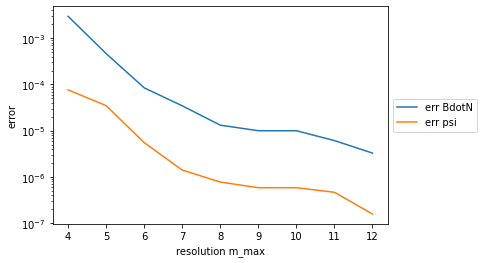

In [180]:
N_post=251
m_max_start=4
m_max_end=12
m_range=np.arange(m_max_start,m_max_end+1)
max_err_psi=np.zeros(m_max_end+1)
max_err_BdotN=np.zeros(m_max_end+1)
for m in m_range:
    print("m_max=%d"%(m))
    res=results[("m_max=%d"%(m))];
    max_err_psi[m]  =np.amax(np.abs(np.sqrt(psidiff(res["x_final"],res["xmap"],psi_fs,N_post))))
    max_err_BdotN[m]=np.amax(np.abs(np.sqrt(BdotN(res["x_final"],res["xmap"],N_post))))
    print ("maximum error in psi_diff= %e" % (max_err_psi[m]))
    print ("maximum error in |B.n|/|B|= %e" % (max_err_BdotN[m]))
    
plt.semilogy(m_range,max_err_BdotN[m_max_start:m_max_end+1],label="err BdotN")
plt.semilogy(m_range,max_err_psi[m_max_start:m_max_end+1],label="err psi")
plt.xlabel('resolution m_max')
plt.ylabel('error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [93]:
#some more post-processing
N_post=251
    
    
rr,zz=eval_curve(x_final,xmap,N_post)
dr_dt,dz_dt=eval_curve_dt(x_final,xmap,N_post)
    
    
n_r=dz_dt/np.sqrt(dr_dt**2+dz_dt**2)
n_z=-dr_dt/np.sqrt(dr_dt**2+dz_dt**2)
Bpol_r,Bpol_z = eval_full_Bpol(rr,zz)
print ("maximum |Bpol|= %e" % (np.amax(np.sqrt(Bpol_r**2+Bpol_z**2))))
print ("maximum error in B.n/|B|= %e" % (np.amax(np.abs(n_r*Bpol_r+n_z*Bpol_z)/np.sqrt(Bpol_r**2+Bpol_z**2))))
    
#circulation
print ("circulation of B,  J=int(B.t)/mu_0  %e" % (np.sum(dr_dt*Bpol_r+dz_dt*Bpol_z)*(1/N_post)/(4.0e-7*np.pi)))
    
B0_r,B0_z=eval_B0pol(rr,zz)
print ("circulation of B0 J=int(B0.t)/mu_0 %e" % (np.sum(dr_dt*B0_r+dz_dt*B0_z)*(1/N_post)/(4.0e-7*np.pi)))


maximum |Bpol|= 1.429963e-02
maximum error in B.n/|B|= 3.275694e-06
circulation of B,  J=int(B.t)/mu_0  4.000000e+04
circulation of B0 J=int(B0.t)/mu_0 4.000000e+04


psi_fs -8.897973e-02, max abs (psi_B0-psi_fs)= 2.776361e-03


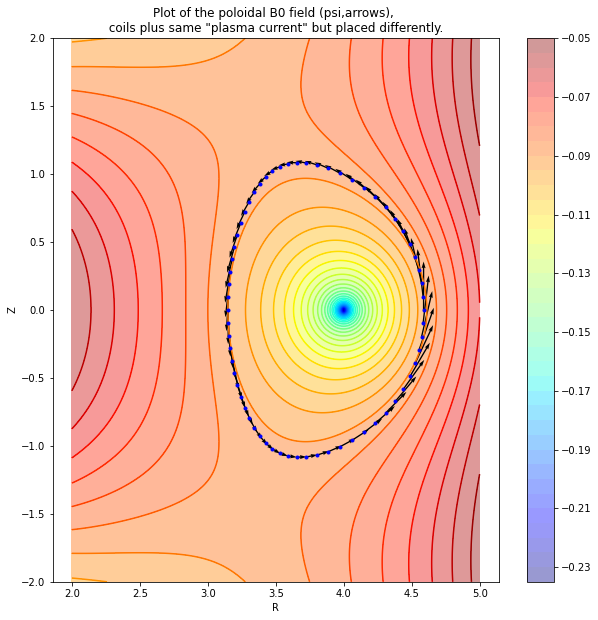

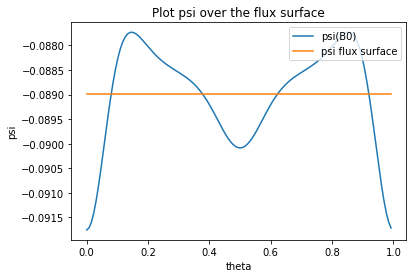

In [186]:


def plot_psi_B0(**kwargs):
 
    R,Z = get_RZ_grid(**kwargs)
    
    psi= eval_psi_B0(R,Z)
    
    fig,ax= plt.subplots(figsize=(10,10))
    
    im=ax.contourf(R, Z, psi, 40, cmap='jet',alpha=0.4)
    ax.contour(R, Z, psi, 40,cmap='jet')
    #ax.plot(coils.coil_arr[:,0],coils.coil_arr[:,1],'x')
    N=64
    rr,zz=eval_curve(x_final,xmap,N)
    
    psi_B0=eval_psi_B0(rr,zz)
    print("psi_fs %e, max abs (psi_B0-psi_fs)= %e" % (psi_fs,np.amax(np.abs(psi_B0-psi_fs))))
    plt.plot(rr,zz,'b.')
    # visualize normalized Bpol 
    B0pol_r,B0pol_z = eval_B0pol(rr,zz)
    # absBpol=np.sqrt(Bpol_r**2+Bpol_z**2)
    ax.quiver(rr,zz,B0pol_r,B0pol_z,width=0.003)
    
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.title('Plot of the poloidal B0 field (psi,arrows), \n coils plus same "plasma current" but placed differently. ')
    fig.colorbar(im)
    ax.axis("equal")
    plt.show()
    
plot_psi_B0()
N=128
thet=np.linspace(0.,1.,N,endpoint=False)
rr,zz=eval_curve(x_final,xmap,N)
psi_B0=eval_psi_B0(rr,zz)
plt.plot(thet,psi_B0,label="psi(B0)")
plt.plot(thet,0*thet+psi_fs,label="psi flux surface")
plt.xlabel('theta')
plt.ylabel('psi')
plt.title('Plot psi over the flux surface')
plt.legend(loc='upper right')
plt.show()

In [173]:
'''
# save data to file (not needed anymore):
N=8# without end-point!
outdat=np.zeros((N,5))

rr,zz=eval_curve(x_final,xmap,N)
B0_R,B0_Z=eval_B0pol(rr,zz)
psi_B0=eval_psi_B0(rr,zz)
outdat[:,0]=rr     # R-coordinate
outdat[:,1]=zz     # Z-coordinate
outdat[:,2]=B0_R # Poloidal field component of B0 in R
outdat[:,3]=B0_Z # Poloidal field component of B0 in Z
outdat[:,4]=1./rr # torodial field component Bphi
#outdat[4,:]=psi_B0 # additional info 

np.savetxt(("outdat_%04d.csv"%(N)), outdat, fmt='%24.17e', delimiter=",")
with open(("out_%04d.cpp"%(N)), 'w') as f:
    for i in range(0,N):
        print("    X_[0][%3d]=%24.17e;X_[2][%3d]=%24.17e; B0_[0][%3d]=%24.17e; B0_[2][%3d]=%24.17e; B0_[1][%3d]=%24.17e; "%(i,rr[i],i,zz[i],i,B0_R[i],i,B0_Z[i],i,1./rr[i]),file=f)

In [189]:
#################
#### COMPUTE BIEST RESULTS
#################

import vacuum_field as vacfield
from scipy.optimize import root
vf = vacfield.vacuum_field()
#vacuum_field.Setup(digits, NFP, Nt, Np, X, Nt, Np);
vf_digits=14
vf_NFP=4
vf_Nt=1



Np_range=[8,12,16,24,32,48,64,96,128]
vf_results={"Np_range":Np_range}

m_max_range=[4,6,9,12]
for m_max in m_max_range:
    which_m_max=("m_max=%d"%(m_max))
    print("===>"+which_m_max)
    res=results[which_m_max]

    x_final,xmap=res["x_final"],res["xmap"]

    for rzcorr in range(0,2):
        print(" ===>rzcorr=",rzcorr)
        if(rzcorr==0):
            case=which_m_max+", no rzcorr"
        else:
            case=which_m_max+", rzcorr"
        vf_results[case]={}
        vf_res=vf_results[case]
        vf_res["max.err Bh_R"]=[]
        vf_res["max.err Bh_Z"]=[]
        vf_res["max.err Bh.N/|Bh|"]=[]
        vf_res["max.err Bref.N/|Bref|"]=[]
        if(rzcorr==0):
            vf_res["max.err Bh.n/|Bh|"]=[]
            vf_res["max.err Bref.n/|Bref|"]=[]
        vf_res["max |psi_diff|"]=[]
        vf_res["max |gradPhi_R|"]=[]
        vf_res["max |gradPhi_Z|"]=[]
        vf_res["max |gradPhi_phi|"]=[]
        
        for vf_Np in Np_range:
            print("     ===> Np=%d"%(vf_Np))  
            rr,zz=eval_curve(x_final,xmap,vf_Np)
            if(rzcorr==1):
                #set points exactly onto the psi_fs contour, via linesearch from curve point into normal direction
                rr_ref,zz_ref=eval_curve(x_final,xmap,vf_Np)
                nr_ref,nz_ref=eval_curve_normal(x_final,xmap,vf_Np)
                for i in range(0,vf_Np):
                    x0_a=0.
                    xp=[rr_ref[i],zz_ref[i]]
                    xs=[nr_ref[i],nz_ref[i]]
                    res_line=root(psi_line, x0_a, args=(xp,xs,psi_fs),tol=1.0e-14)
                    rr[i],zz[i]=eval_line(res_line.x,xp,xs)


            psi_curve=eval_full_psi(rr,zz)
            psi_diff=np.amax(np.sqrt((psi_curve-psi_fs)**2/(psi_fs**2)))
            print("max |psi_diff|=%e "%(psi_diff))
            vf_res["max |psi_diff|"].append(psi_diff)

            #prepare surface data for BIEST setup
            XX=np.zeros((3,vf_Np))
            XX[0,:]=rr
            XX[2,:]=zz
            vf.Setup(vf_digits,vf_NFP,vf_Nt,vf_Np,XX.flatten(),vf_Nt,vf_Np)

            #test=np.zeros((3,vf_Np))
            #N=np.zeros((3,vf_Np))
            #for dd in [0,1,2]:
            #    test[dd,:]=1.
            #    N[dd,:]=vf.ComputeBdotN(test.flatten())
            #    test[dd,:]=0.

            B0_R,B0_Z=eval_B0pol(rr,zz)
            #prepare B0 data
            B0=np.zeros((3,vf_Np))
            B0[0,:]=B0_R # Poloidal field component of B0 in R
            B0[2,:]=B0_Z # Poloidal field component of B0 in Z
            B0[1,:]=1./rr # torodial field component Bphi

            #solution steps in BIEST
            B0dotN=vf.ComputeBdotN(B0.flatten())
            gradPhi,sigma=vf.ComputeGradPhi(B0dotN)
            gradPhi=np.asarray(gradPhi).reshape((3,vf_Np))

            Bh_R=B0[0,:]-gradPhi[0,:]
            Bh_Z=B0[2,:]-gradPhi[2,:]
            Bh_phi=B0[1,:]-gradPhi[1,:]
            Bh=np.zeros((3,vf_Np))
            Bh[0,:]=Bh_R # Poloidal field component of B0 in R
            Bh[2,:]=Bh_Z # Poloidal field component of B0 in Z
            Bh[1,:]=Bh_phi # torodial field component Bphi


            Bref_R,Bref_Z=eval_full_Bpol(rr,zz)
            Bref=np.zeros((3,vf_Np))
            Bref[0,:]=Bref_R # Poloidal field component of B0 in R
            Bref[2,:]=Bref_Z # Poloidal field component of B0 in Z
            Bref[1,:]=1./rr # torodial field component Bphi




            vf_res["max.err Bh_R"].append(np.amax(np.abs(Bh_R-Bref_R)))
            vf_res["max.err Bh_Z"].append(np.amax(np.abs(Bh_Z-Bref_Z)))
            print ("max err Bh_R/Z  = %e %e" % (vf_res["max.err Bh_R"][-1],vf_res["max.err Bh_Z"][-1]))

            vf_res["max |gradPhi_R|"].append(np.amax(np.abs(gradPhi[0,:])))
            vf_res["max |gradPhi_Z|"].append(np.amax(np.abs(gradPhi[2,:])))
            vf_res["max |gradPhi_phi|"].append(np.amax(np.abs(gradPhi[1,:])))
            print ("max |gradPhi_R/Z/phi|= %e %e %e " % (vf_res["max |gradPhi_R|"][-1],vf_res["max |gradPhi_Z|"][-1],vf_res["max |gradPhi_phi|"][-1]))

            if(rzcorr==0):
                n_r,n_z=eval_curve_normal(x_final,xmap,vf_Np)
                vf_res["max.err Bh.n/|Bh|"].append(np.amax(np.abs(n_r*Bh_R+n_z*Bh_Z)/np.sqrt(Bh_R**2+Bh_Z**2)))
                print ("maximum error in Bh.n/|Bh|= %e" % (vf_res["max.err Bh.n/|Bh|"][-1]))
                vf_res["max.err Bref.n/|Bref|"].append(np.amax(np.abs(n_r*Bref_R+n_z*Bref_Z)/np.sqrt(Bref_R**2+Bref_Z**2)))
                print ("maximum error in Bref.n/|Bref|= %e" % (vf_res["max.err Bref.n/|Bref|"][-1]))
            BhdotN=vf.ComputeBdotN(Bh.flatten())
            vf_res["max.err Bh.N/|Bh|"].append(np.amax(np.abs(BhdotN/np.sqrt(Bh_R**2+Bh_Z**2))))
            print ("maximum error in Bh.N/|Bh|= %e" % (vf_res["max.err Bh.N/|Bh|"][-1]))
            BrefdotN=vf.ComputeBdotN(Bref.flatten())
            vf_res["max.err Bref.N/|Bref|"].append(np.amax(np.abs(BrefdotN/np.sqrt(Bref_R**2+Bref_Z**2))))
            print ("maximum error in Bref.N/|Bref|= %e" % (vf_res["max.err Bref.N/|Bref|"][-1]))

===>m_max=4
 ===>rzcorr= 0
     ===> Np=8
max |psi_diff|=5.258304e-05 
max err Bh_R/Z  = 1.995016e-04 1.492658e-03
max |gradPhi_R/Z/phi|= 4.711665e-04 3.972168e-04 2.549901e-16 
maximum error in Bh.n/|Bh|= 6.084661e-02
maximum error in Bref.n/|Bref|= 2.582873e-03
maximum error in Bh.N/|Bh|= 7.563677e-16
maximum error in Bref.N/|Bref|= 6.161945e-02
     ===> Np=12
max |psi_diff|=6.705648e-05 
max err Bh_R/Z  = 9.071758e-05 3.490799e-04
max |gradPhi_R/Z/phi|= 1.399804e-03 1.675022e-03 3.430046e-16 
maximum error in Bh.n/|Bh|= 6.812012e-15
maximum error in Bref.n/|Bref|= 2.685533e-03
maximum error in Bh.N/|Bh|= 1.461634e-15
maximum error in Bref.N/|Bref|= 2.685533e-03
     ===> Np=16
max |psi_diff|=5.258304e-05 
max err Bh_R/Z  = 3.429483e-05 1.126183e-04
max |gradPhi_R/Z/phi|= 1.669992e-03 1.832493e-03 6.829837e-16 
maximum error in Bh.n/|Bh|= 6.109841e-15
maximum error in Bref.n/|Bref|= 2.582873e-03
maximum error in Bh.N/|Bh|= 2.555618e-15
maximum error in Bref.N/|Bref|= 2.582873e-03
  

max |psi_diff|=1.559657e-15 
max err Bh_R/Z  = 1.341471e-04 4.973734e-04
max |gradPhi_R/Z/phi|= 1.055268e-03 1.371170e-03 2.720810e-16 
maximum error in Bh.N/|Bh|= 1.321499e-15
maximum error in Bref.N/|Bref|= 9.295945e-03
     ===> Np=16
max |psi_diff|=1.559657e-15 
max err Bh_R/Z  = 3.403919e-05 9.100876e-05
max |gradPhi_R/Z/phi|= 1.554641e-03 1.777535e-03 1.848929e-16 
maximum error in Bh.N/|Bh|= 9.363795e-16
maximum error in Bref.N/|Bref|= 1.147576e-04
     ===> Np=24
max |psi_diff|=1.559657e-15 
max err Bh_R/Z  = 1.663159e-06 5.567482e-06
max |gradPhi_R/Z/phi|= 1.642085e-03 1.862976e-03 4.082999e-16 
maximum error in Bh.N/|Bh|= 1.416554e-15
maximum error in Bref.N/|Bref|= 1.046296e-05
     ===> Np=32
max |psi_diff|=1.559657e-15 
max err Bh_R/Z  = 9.981341e-08 3.755635e-07
max |gradPhi_R/Z/phi|= 1.529209e-03 1.868168e-03 5.936155e-16 
maximum error in Bh.N/|Bh|= 1.325358e-15
maximum error in Bref.N/|Bref|= 7.515773e-06
     ===> Np=48
max |psi_diff|=1.715623e-15 
max err Bh_R/Z  = 1

max err Bh_R/Z  = 6.810571e-08 1.735778e-07
max |gradPhi_R/Z/phi|= 1.536999e-03 1.868372e-03 7.358322e-16 
maximum error in Bh.n/|Bh|= 1.916673e-14
maximum error in Bref.n/|Bref|= 2.770099e-06
maximum error in Bh.N/|Bh|= 1.210815e-15
maximum error in Bref.N/|Bref|= 2.770099e-06
     ===> Np=48
max |psi_diff|=1.574777e-07 
max err Bh_R/Z  = 3.956336e-08 4.727805e-08
max |gradPhi_R/Z/phi|= 1.636818e-03 1.868593e-03 4.541919e-16 
maximum error in Bh.n/|Bh|= 1.992350e-14
maximum error in Bref.n/|Bref|= 2.917009e-06
maximum error in Bh.N/|Bh|= 1.576365e-15
maximum error in Bref.N/|Bref|= 2.917009e-06
     ===> Np=64
max |psi_diff|=1.574777e-07 
max err Bh_R/Z  = 4.685859e-08 4.769380e-08
max |gradPhi_R/Z/phi|= 1.673857e-03 1.868593e-03 5.541433e-16 
maximum error in Bh.n/|Bh|= 3.298503e-14
maximum error in Bref.n/|Bref|= 3.273724e-06
maximum error in Bh.N/|Bh|= 1.538836e-15
maximum error in Bref.N/|Bref|= 3.273724e-06
     ===> Np=96
max |psi_diff|=1.574777e-07 
max err Bh_R/Z  = 4.120158e-

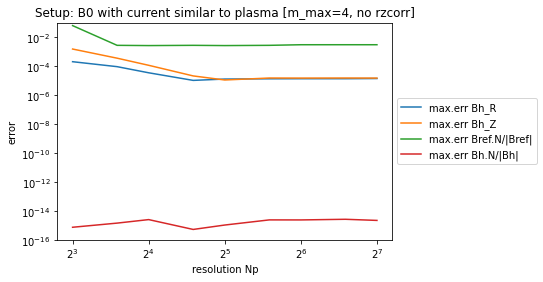

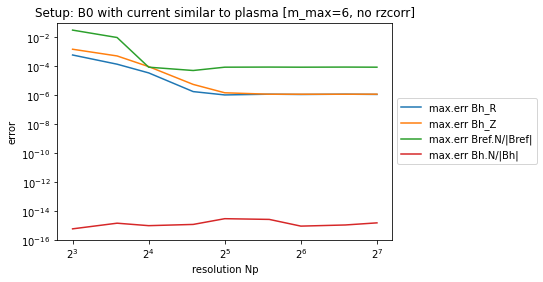

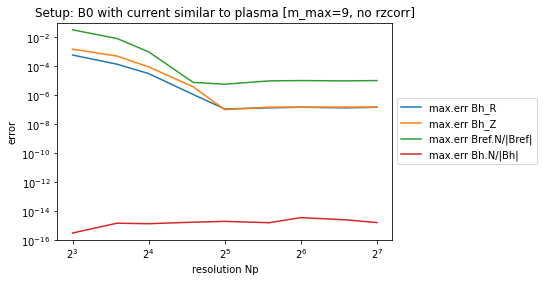

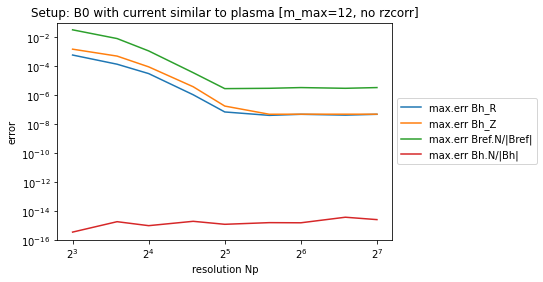

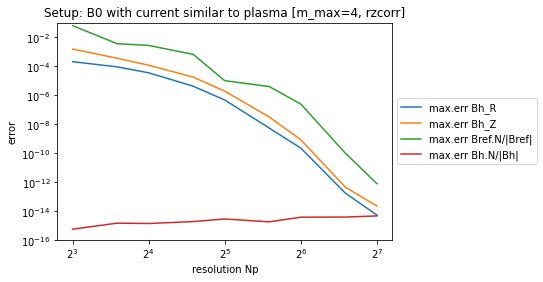

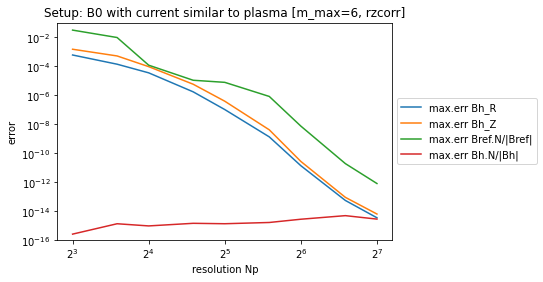

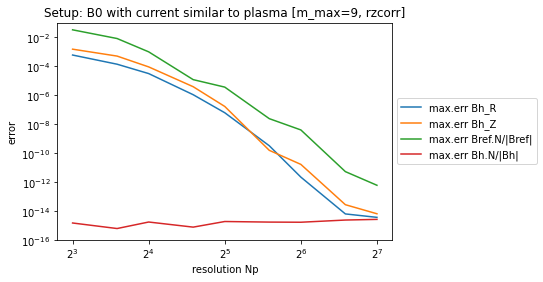

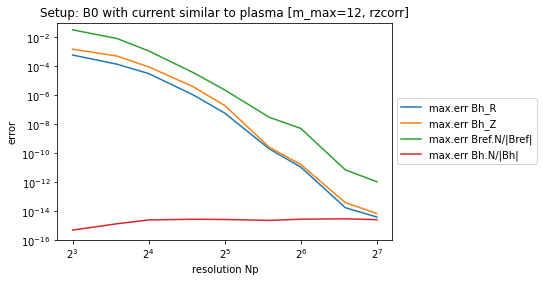

In [192]:
main_keys=["m_max=4, no rzcorr",
           "m_max=6, no rzcorr",
           "m_max=9, no rzcorr",
           "m_max=12, no rzcorr",
           "m_max=4, rzcorr",
           "m_max=6, rzcorr",
           "m_max=9, rzcorr",
           "m_max=12, rzcorr",
          ]
sub_keys=["max.err Bh_R",
          "max.err Bh_Z",
          "max.err Bref.N/|Bref|",
          "max.err Bh.N/|Bh|",
          ]
          

for main_key in main_keys:
    fig, ax = plt.subplots()
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    for key in sub_keys:
        plt.plot(Np_range, vf_results[main_key][key],label=key)


    plt.xlabel('resolution Np')
    plt.ylabel('error')
    plt.ylim([1e-16, 1e-1])
    plt.title("Setup: B0 with current similar to plasma ["+main_key+"]")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()